# INTRODUCTION
* It’s a Python based scientific computing package targeted at two sets of audiences:
    * A replacement for NumPy to use the power of GPUs
    * Deep learning research platform that provides maximum flexibility and speed
* pros:
    * Iinteractively debugging PyTorch. Many users who have used both frameworks would argue that makes pytorch significantly easier to debug and visualize.
    * Clean support for dynamic graphs
    * Organizational backing from Facebook
    * Blend of high level and low level APIs
* cons:
    * Much less mature than alternatives
    * Limited references / resources outside of the official documentation
* I accept you know neural network basics. If you do not know check my tutorial. Because I will not explain neural network concepts detailed, I only explain how to use pytorch for neural network
* Neural Network tutorial: https://www.kaggle.com/kanncaa1/deep-learning-tutorial-for-beginners
* The most important parts of this tutorial from matrices to ANN. If you learn these parts very well, implementing remaining parts like CNN or RNN will be very easy.

Content:
1. Basics of Pytorch, Linear Regression, Logistic Regression, Artificial Neural Network (ANN), Concolutional Neural Network (CNN)
    * https://www.kaggle.com/kanncaa1/pytorch-tutorial-for-deep-learning-lovers/code
1. Recurrent Neural Network (RNN)
1. Long-Short Term Memory (LSTM)
    * https://www.kaggle.com/kanncaa1/long-short-term-memory-with-pytorch

Long-Short Term Memory (LSTM)
<br>
<br>**Steps of LSTM:**
1. Import Libraries
1. Prepare Dataset
1. Create LSTM Model
    1. hidden layer dimension is 100
    1. number of hidden layer is 1
1. Instantiate Model
1. Instantiate Loss
    1. Cross entropy loss
    1. It also has softmax(logistic function) in it.
1. Instantiate Optimizer
    1. SGD Optimizer
1. Traning the Model
1. Prediction

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
# Import Libraries
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

Epoch Number:  17


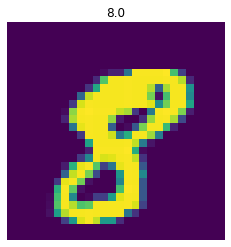

33600
8400


In [3]:
# load data
train = pd.read_csv(r"/kaggle/input/digit-recognizer/train.csv",dtype = np.float32)

# split data into features(pixels) and labels(numbers from 0 to 9)
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255 # normalization

# train test split. Size of train data is 80% and size of test data is 20%. 
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42) 

# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

# batch_size, epoch and iteration
batch_size = 100
n_iters = 6000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)
print("Epoch Number: ",num_epochs)

# Pytorch train and test sets
train = TensorDataset(featuresTrain,targetsTrain)
test = TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

# visualize one of the images in data set
plt.imshow(features_numpy[10].reshape(28,28))
plt.axis("off")
plt.title(str(targets_numpy[10]))
plt.savefig('graph.png')
plt.show()

print(len(train_loader.dataset))
print(len(test_loader.dataset))


In [4]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # LSTM
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True) # batch_first=True (batch_dim, seq_dim, feature_dim)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # 28 time steps
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    
input_dim = 28
hidden_dim = 100
layer_dim = 1
output_dim = 10
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)

error = nn.CrossEntropyLoss()

learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 

In [5]:
# Number of steps to unroll
seq_dim = 28  
loss_list = []
iteration_list = []
accuracy_list = []
count = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images as a torch tensor with gradient accumulation abilities
        images = images.view(-1, seq_dim, input_dim).requires_grad_()

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        # outputs.size 100, 10
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = error(outputs, labels)

        # Getting gradients
        loss.backward()

        # Updating parameters
        optimizer.step()

        count += 1

        if count % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            for images, labels in test_loader:
                
                images = images.view(-1, seq_dim, input_dim)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / total
            
            loss_list.append(loss.data.item())
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(count, loss.data.item(), accuracy))

Iteration: 500. Loss: 2.2632083892822266. Accuracy: 20
Iteration: 1000. Loss: 1.0473525524139404. Accuracy: 68
Iteration: 1500. Loss: 0.3276382088661194. Accuracy: 85
Iteration: 2000. Loss: 0.3219815194606781. Accuracy: 91
Iteration: 2500. Loss: 0.161108136177063. Accuracy: 94
Iteration: 3000. Loss: 0.15422266721725464. Accuracy: 96
Iteration: 3500. Loss: 0.15331733226776123. Accuracy: 96
Iteration: 4000. Loss: 0.016343142837285995. Accuracy: 96
Iteration: 4500. Loss: 0.05299708992242813. Accuracy: 97
Iteration: 5000. Loss: 0.047467898577451706. Accuracy: 97
Iteration: 5500. Loss: 0.158019557595253. Accuracy: 96


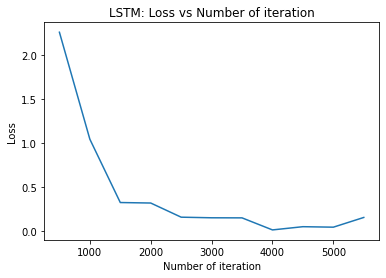

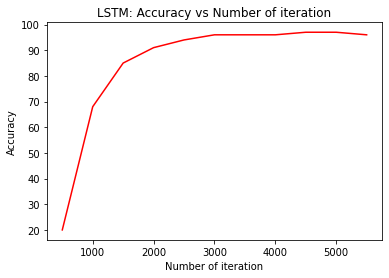

In [6]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("LSTM: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("LSTM: Accuracy vs Number of iteration")
plt.savefig('graph.png')
plt.show()

## Conclusion
In this tutorial, we learn:

1. Basics of pytorch
1. Linear regression with pytorch
1. Logistic regression with pytorch
1. Artificial neural network with with pytorch
1. Convolutional neural network with pytorch
    1. https://www.kaggle.com/kanncaa1/pytorch-tutorial-for-deep-learning-lovers/code
1. Recurrent neural network with pytorch
1. Long-Short Term Memory (LSTM)
    1. https://www.kaggle.com/kanncaa1/long-short-term-memory-with-pytorch

If you have any question or suggest, I will be happy to hear it